# **DS3000 Final Project: NBA Salary Predictor**
## Team 36

- Andrew Lin (lin.andr@northeastern.edu)
- Hriday Sabir (sabir.h@northeastern.edu)
- Antonis Vekios (vekios.a@northeastern.edu)
- Ethan Gilworth (gilworth.e@northeastern.edu)

### **Re-use Permissions**

The following may be re-used for any purposes:
- All data included with submission
- All images
- This report and the notebooks which collected/cleaned the data
- Associated video presentation

Please attribute any work to the authors listed above.

# **Executive Summary**
It seems that every year there are some seemingly outrageous player contracts in the NBA where player's are marginally overpaid or underpaid. In an attempt to understand the rationale behind a player's salary, [we retrieved statistics and salaries from basketballreference.com for the 2020-2021 NBA season](#data).
 We handled the data and plotted [several graphs](#graphs) to visualize the correlation between various statistics and NBA player salary. Using the data from basketballreference.com, we used machine learning techniques including [Lasso](#lasso) with built-in capabilities to ignore redudant statistics and [Random Forest Regression](#rf) to predict feature importance and create models to predict NBA player salary. The results of our models provide [fascinating insights](#insights) into the worth of player contracts and depict that there is undoubtedly a connection between certain statistics and a player's salary. However, it is important to recognize that our models are not perfect, and fail to encompass all the variables relevant for determining a player's salary.


# **Introduction**

The decisions behind player salaries in a league like the NBA are the driving force behind team and business success and longevity. Determining the factors that are relevant to player salaries are vital in the decision making process.

Overestimating the right salary can create deficits in allocations leading to a crippling contract such as that of [Chandler Parsons in Memphis](https://www.commercialappeal.com/story/sports/columnists/mark-giannotto/2019/01/06/chandler-parsons-contract-memphis-grizzlies-chris-wallace/2498317002/), and underestimating salaries can leave the long-term health of player contracts in jeopardy, such as [Lou Williams' bargain contract](https://discover.hubpages.com/sports/Lou-Williams-Underpaid-and-Undervalued). 

This project seeks to answer the question: "Which factors are critical in determining player salary, and how do we identify them?"

# **Ethical Considerations**

One error of judgment created by this proejct will be that of the difference between value and salary. This team is cognizant of this fact and does not endorse or wish to use this model to predict someone's value. It goes without saying that there is no relation between someone's salary and their value as a person to an organization. This model fails to consider intangible value brought by a player: their experience, locker room presence, leadership qualities and general veteran skill. We recognise these challenges. 

There will also be a bias in the model. Players who are underpaid will continue to be recognised as so by the model. 


# **Data Description**

## Data Overview 
We will scrape [player data corresponding to the 2020-2021 NBA Season from Basketball-Reference](https://www.basketball-reference.com/) for the per game, per 100 posession and advanced categories.  

<img src="https://i.ibb.co/8cpvVdc/Capture.jpg" width=800px>

<a id='data'></a>

From this table, for each game, we can obtain:
- Games Played
- Minutes Per Game 
- Player Efficiency Rating 
- Offensive Win Shares	
- Defensive Win Shares 
- Win Shares
- Win Shares per 48 minutes	
- Offensive Box Plus Minus	
- Defensive Box Plus Minus	
- Box Plus Minus (Overall)	
- Value over Replacement Player 
- Field Goals Made
- Field Goals Attempted	
- FG%
- 3 Pointers Made
- 3 Pointers Attempted	
- 3P%
- 2 Pointers Made
- 2 Pointers Attempted	
- 2P%	
- Free Throws Made	
- Free Throws Attempted
- FT%
- Offensive/Defensive/Total Rebounds	
- Assists
- Steals
- Blocks
- Turnovers


<img src="https://i.ibb.co/w6LHNDH/Capture.jpg" width=800px>

Additionally, we will scrape NBA player salary data for the 2020-21 season using the table above.

We will be joining the data across the multiple per game, per posession and advanced categories into one table. This may cause multiple indexes as well as players who have switched teams in the season to be repeated under two different teams, and will require cleaning of the data.

## RAPM Data for 2020-2021 NBA season

Using NBA's API we are able to fetch play-by-play data for any and all games of an NBA season. We can then clean that data, combine it, and then parse it into a matrix that describes every play with a list of players on offense or defense, and then run Bayesian ridge regression in order to predict a players impact on the game's scoring margins. This process is known as Regularized Adjusted Plus-Minus. Using a system one of our members created we can get this RAPM data for any NBA season


### Pipeline Overview

We will accomplish this task with these functions:
- `get_url()`
    - returns a dataframe taken from the tables of given url
- `clean_stats()`
    - cleans nba player stat data to contain only pertinent information by removing unwanted or excess rows and columns to prepare the dataframe for merging
- `clean_salary_data()`
    - cleans the nba player salary data using rename_column to fix column names and salary_to_float to convert salaries to usable floats. Removes the original multindexes and unnecessary columms so the resulting dataframe can be merged
- `join_data()`
    - merge all the given dataframes containing our NBA player data on a given index 
- `rename_column()`
    - helper function to change the name column in a dataframe
- `salary_to_float()`
    - helper function to change the salary values to floats 
    

## Pipeline
#### Scrape list of games

In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

In [ ]:
# Import 2021 RAPM data from Github

rapm_2021 = pd.read_csv('https://raw.githubusercontent.com/EthanRiley/rapm_data_fix/main/rapm20-21.csv')

rapm_2021.head()

,playerId,playerName,LA_RAPM,LA_RAPM_Rank,LA_RAPM__Def,LA_RAPM__Def_Rank,LA_RAPM__Off,LA_RAPM__Off_Rank,RA_EFG,RA_EFG_Rank,RA_EFG__Def,RA_EFG__Def_Rank,RA_EFG__Off,RA_EFG__Off_Rank,RA_FTR,RA_FTR_Rank,RA_FTR__Def,RA_FTR__Def_Rank,RA_FTR__Off,RA_FTR__Off_Rank,RA_ORBD,RA_ORBD_Rank,RA_ORBD__Def,RA_ORBD__Def_Rank,RA_ORBD__Off,RA_ORBD__Off_Rank,RA_TOV,RA_TOV_Rank,RA_TOV__Def,RA_TOV__Def_Rank,RA_TOV__Off,RA_TOV__Off_Rank,RAPM,RAPM_Rank,RAPM__Def,RAPM__Def_Rank,RAPM__Off,RAPM__Off_Rank,season,teamId,teamName,primaryKey
0,101108,Chris Paul,0.91,73,0.38,130,0.53,101,1.12,29,0.61,44,0.52,82,-0.38,368,0.20,156,-0.58,436,-0.09,274,0.13,205,-0.22,319,0.40,103,0.26,112,0.14,169,2.16,29,1.34,35,0.82,107,2020-21,1610612756,PHX,101108_2020-21
1,1628969,Mikal Bridges,0.46,145,-0.43,380,0.88,60,1.12,30,0.48,67,0.64,60,-0.02,255,0.05,225,-0.07,286,0.11,228,-0.26,337,0.38,142,-0.25,353,-0.16,351,-0.09,304,1.58,57,0.45,135,1.13,71,2020-21,1610612756,PHX,1628969_2020-21
2,101150,Lou Williams,-0.57,376,-0.37,365,-0.20,297,0.49,118,0.39,84,0.10,182,-0.30,350,-0.37,381,0.07,221,-0.72,376,-0.89,454,0.17,193,-0.10,294,-0.14,339,0.03,221,0.94,110,0.13,206,0.81,108,2020-21,1610612746,LAC,101150_2020-21
3,1626153,Delon Wright,1.27,46,0.44,123,0.83,64,-0.65,410,-0.64,455,0.01,228,1.02,40,0.27,133,0.75,35,-0.21,296,-0.40,365,0.19,185,1.46,7,0.49,52,0.97,8,0.75,127,-0.32,340,1.07,78,2020-21,1610612765,DET,1626153_2020-21
4,1626157,Karl-Anthony Towns,0.23,184,-0.38,369,0.61,92,0.69,79,0.17,172,0.52,81,0.43,121,0.33,114,0.10,203,0.90,91,0.11,215,0.79,70,-0.05,268,-0.07,299,0.02,232,1.09,99,-0.02,258,1.11,74,2020-21,1610612750,MIN,1626157_2020-21


In [ ]:
def get_url(url):
    """ gets a dataframe of data from the given url
    
    Args:
        url (String): the url to request data from
        
    Returns:
        data (DataFrame): the dataframe from the url
    """
    # Gets a list of dataframes from the given url and returns
    # the first dataframe from the list
    data = pd.read_html(url)[0]
    return data

# Get tables
advanced_stats_2021 = get_url('https://www.basketball-reference.com/leagues/NBA_2021_advanced.html')
per_poss_2021 = get_url('https://www.basketball-reference.com/leagues/NBA_2021_per_poss.html')
df_salary = get_url('https://www.basketball-reference.com/contracts/players.html')

In [ ]:
def rename_column(df, title_old, title_new):
  '''
  Args:
  df (DataFrame): Dataframe
  title_old (string): title of column to be changed
  title_new (string): new title for column

  returns: df (DataFrame): Dataframe with completed change
'''
  #df[title_new] = df[title_old]
  #del df[title_old]

  df = df.rename(columns={title_old: title_new})

  return df

# Fix format of RAPM data so it can be joined later

rapm_2021 = rename_column(rapm_2021, 'playerName', 'Player')
rapm_2021.head()

,playerId,Player,LA_RAPM,LA_RAPM_Rank,LA_RAPM__Def,LA_RAPM__Def_Rank,LA_RAPM__Off,LA_RAPM__Off_Rank,RA_EFG,RA_EFG_Rank,RA_EFG__Def,RA_EFG__Def_Rank,RA_EFG__Off,RA_EFG__Off_Rank,RA_FTR,RA_FTR_Rank,RA_FTR__Def,RA_FTR__Def_Rank,RA_FTR__Off,RA_FTR__Off_Rank,RA_ORBD,RA_ORBD_Rank,RA_ORBD__Def,RA_ORBD__Def_Rank,RA_ORBD__Off,RA_ORBD__Off_Rank,RA_TOV,RA_TOV_Rank,RA_TOV__Def,RA_TOV__Def_Rank,RA_TOV__Off,RA_TOV__Off_Rank,RAPM,RAPM_Rank,RAPM__Def,RAPM__Def_Rank,RAPM__Off,RAPM__Off_Rank,season,teamId,teamName,primaryKey
0,101108,Chris Paul,0.91,73,0.38,130,0.53,101,1.12,29,0.61,44,0.52,82,-0.38,368,0.20,156,-0.58,436,-0.09,274,0.13,205,-0.22,319,0.40,103,0.26,112,0.14,169,2.16,29,1.34,35,0.82,107,2020-21,1610612756,PHX,101108_2020-21
1,1628969,Mikal Bridges,0.46,145,-0.43,380,0.88,60,1.12,30,0.48,67,0.64,60,-0.02,255,0.05,225,-0.07,286,0.11,228,-0.26,337,0.38,142,-0.25,353,-0.16,351,-0.09,304,1.58,57,0.45,135,1.13,71,2020-21,1610612756,PHX,1628969_2020-21
2,101150,Lou Williams,-0.57,376,-0.37,365,-0.20,297,0.49,118,0.39,84,0.10,182,-0.30,350,-0.37,381,0.07,221,-0.72,376,-0.89,454,0.17,193,-0.10,294,-0.14,339,0.03,221,0.94,110,0.13,206,0.81,108,2020-21,1610612746,LAC,101150_2020-21
3,1626153,Delon Wright,1.27,46,0.44,123,0.83,64,-0.65,410,-0.64,455,0.01,228,1.02,40,0.27,133,0.75,35,-0.21,296,-0.40,365,0.19,185,1.46,7,0.49,52,0.97,8,0.75,127,-0.32,340,1.07,78,2020-21,1610612765,DET,1626153_2020-21
4,1626157,Karl-Anthony Towns,0.23,184,-0.38,369,0.61,92,0.69,79,0.17,172,0.52,81,0.43,121,0.33,114,0.10,203,0.90,91,0.11,215,0.79,70,-0.05,268,-0.07,299,0.02,232,1.09,99,-0.02,258,1.11,74,2020-21,1610612750,MIN,1626157_2020-21


In [ ]:
import pandas as pd

def clean_stats(stats_df, stats, drop=False):
    """ Cleans the dataframe of stats to keep only the stats
    specified in the list stats

    Args:
      stats (list): a list of stats they should be selected
      drop (Boolean): if true, drop the list of stats from the table,
                      otherwise keep them

    Returns:
      stats_df (DataFrame): updated dataframe with only the selected stats 
    """
    # If drop is true, drop the list of columns
    if drop:
      stats_df = stats_df.drop(stats, axis=1)
    else:
      # else select only the list of columns
      stats_df = stats_df[stats]

    # remove any columns with NaN
    stats_df = stats_df.dropna(axis=1, how='all')

    # remove excess rows
    stats_df = stats_df[stats_df.Player != 'Player']

    # output
    return stats_df

advanced_index_list = ['Player', 'Pos', 'Tm', 'G', 'MP', 'PER', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
per_poss_index_list = ['Pos', 'Tm', 'Age', 'G', 'GS', 'MP']
rapm_index_list = ['Player','RAPM', 'RAPM__Off', 'RAPM__Def']

# Clean our tables
advanced_stats_2021_clean = clean_stats(advanced_stats_2021, advanced_index_list)
per_poss_2021_clean = clean_stats(per_poss_2021, per_poss_index_list, drop=True)
rapm_2021_clean = clean_stats(rapm_2021, rapm_index_list)

rapm_2021_clean.head()

,Player,RAPM,RAPM__Off,RAPM__Def
0,Chris Paul,2.16,0.82,1.34
1,Mikal Bridges,1.58,1.13,0.45
2,Lou Williams,0.94,0.81,0.13
3,Delon Wright,0.75,1.07,-0.32
4,Karl-Anthony Towns,1.09,1.11,-0.02


In [ ]:
def salary_to_float(salary):
    """Converts a string representing a player's salary to a float
    Args:
        salary (str): the salary of the player in string format (e.g. '$2,582,160')
    Returns:
        float_salary (float): the salary in a float data type
    """
    float_salary = float(''.join(salary.split('$')[1:][0].split(',')))
    return float_salary

def clean_salary_data(df_salary):
    """ cleans a dataframe containing NBA player salary data 
    
    Args:
        df_salary (DataFrame): dataframe containing NBA player salary data
        
    Returns:
        df_salary_clean (DataFrame): cleaned dataframe containing NBA player salary data
    """

    # Indexez to keep
    list_indexes = [('Unnamed: 1_level_0', 'Player'), ('Salary', '2020-21')]

    # Select the indexes
    df_salary_clean = df_salary.loc[:,list_indexes]

    # Transpose the dataframe to remove multindexing
    df_salary_clean = df_salary_clean.T.reset_index().set_index('level_1').T[1:]

    # Rename the column indexes
    df_salary_clean = df_salary_clean.rename(columns={'2020-21': 'Salary 2020-21'})

    # Remove excess columns
    df_salary_clean = df_salary_clean[df_salary_clean.Player != 'Player']
    df_salary_clean.dropna(axis=0, inplace = True)

    # Convert salary to float values
    df_salary_clean['Salary 2020-21'] = df_salary_clean['Salary 2020-21'].map(salary_to_float)

    # output
    return df_salary_clean
    
# clean salary table
df_salary_clean = clean_salary_data(df_salary)
df_salary_clean.head()

level_1,Player,Salary 2020-21
0,Stephen Curry,43006362.0
1,Russell Westbrook,41358814.0
2,Chris Paul,41358814.0
3,John Wall,41254920.0
4,James Harden,40824000.0


In [ ]:
def join_data(dfs_list, key):
  """merges all the dataframes in the list based on the given key

  Args:
    dfs_list (list): A list of the dataframes to be merged
    key (list): The key(s) to be merged on

  Return:
    all_stats_df (DataFrame): A dataframe containing all the merged dataframes data
  """
  # Take the first dataframe
  all_stats_df = dfs_list[0]

  # Merge every dataframe onto the first one
  for right_df in dfs_list[1:]:
    all_stats_df = pd.merge(all_stats_df, right_df, on=key)

  # Drop duplicates
  all_stats_df.drop_duplicates([key], inplace=True)
  
  # output
  return all_stats_df

# List of dataframes to be merged
dfs_list = [advanced_stats_2021_clean, per_poss_2021_clean, rapm_2021_clean, df_salary_clean]

# Merge the dataframes on Player
all_stats_df = join_data(dfs_list, 'Player')
all_stats_df.head()


,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Rk,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21
0,Precious Achiuwa,PF,MIA,54,681,13.9,0.2,1.0,1.2,.088,-3.5,-0.8,-4.3,-0.4,1,8.1,15.1,.541,0.0,0.0,NaN,8.1,15.1,.541,3.8,7.3,.515,5.1,9.2,14.3,2.0,1.3,1.9,3.0,6.4,20.1,106,108,-1.12,-1.22,0.10,2582160.0
1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,.116,-0.1,-0.6,-0.7,0.5,3,5.8,9.3,.620,0.0,0.1,.000,5.8,9.2,.627,1.8,4.1,.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0
2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,.193,2.8,1.7,4.5,2.8,4,10.7,18.9,.566,0.1,0.2,.250,10.6,18.7,.570,6.7,8.4,.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0
3,LaMarcus Aldridge,C,TOT,26,674,15.7,0.5,0.7,1.2,.086,-0.2,-0.4,-0.6,0.2,5,10.1,21.3,.473,2.2,5.8,.388,7.8,15.5,.505,2.9,3.4,.872,1.4,7.1,8.5,3.5,0.8,2.1,1.9,3.4,25.3,109,112,-0.46,0.01,-0.48,19078340.0
21,Nickeil Alexander-Walker,SG,NOP,41,851,12.6,-0.2,0.8,0.6,.034,-1.6,-0.1,-1.7,0.1,7,9.0,21.5,.418,3.7,10.6,.348,5.3,10.9,.487,2.2,3.0,.750,0.6,6.6,7.2,4.6,2.3,1.2,3.2,4.4,23.9,101,113,-1.12,-1.05,-0.07,3113160.0


In [ ]:
# saving cleaned data as csv file
all_stats_df.to_csv('all_stats_df.csv')

## Visualizations (sanity check / data exploration)

Although the pipeline above does not take too long to run, we decided to first save the cleaned data in csv file format and then read that file in order to generate the visualizations below. This allows us to:
- create a backup of our data on a local file
- read through the entire dataset by openning up the csv file (note that since our dataframe consists of many rows, previewing the dataframe in a jupyter notebook would be inefficient as we are only able to see the first and last few rows of the data)

<a id='graphs'></a>


#### Correlations between category tags

In [ ]:
# read the data from the csv file
all_stats_df = pd.read_csv('all_stats_df.csv')

In [ ]:
# calculate correlation of all player stats (columns) with player salary
salary_corr_df = pd.DataFrame({'Salary correlation':all_stats_df.corrwith(all_stats_df['Salary 2020-21'])[1:]})
salary_corr_df

,Salary correlation
G,0.187676
MP,0.486467
PER,0.535908
OWS,0.506891
DWS,0.443824
WS,0.542817
WS/48,0.348038
OBPM,0.570162
DBPM,0.123392
BPM,0.522706


For the visualizations below, we chose to focus on the NBA player statistics that are more strongly correlated with salaries. 

In [ ]:
# getting the stats that have a correlation greater or equal to 0.45 with player salaries
# these are the stats that are 'strongly correlated' with player salaries
salary_corr_df[salary_corr_df['Salary correlation']>=0.45][:-1]

,Salary correlation
MP,0.486467
PER,0.535908
OWS,0.506891
WS,0.542817
OBPM,0.570162
BPM,0.522706
VORP,0.646179
FG,0.519491
FGA,0.474645
FT,0.484777


Plotting a bar chart of the correlation of different player stats with player salaries allows us to easily identify factors that are more important than others when determining a player's salary or value:

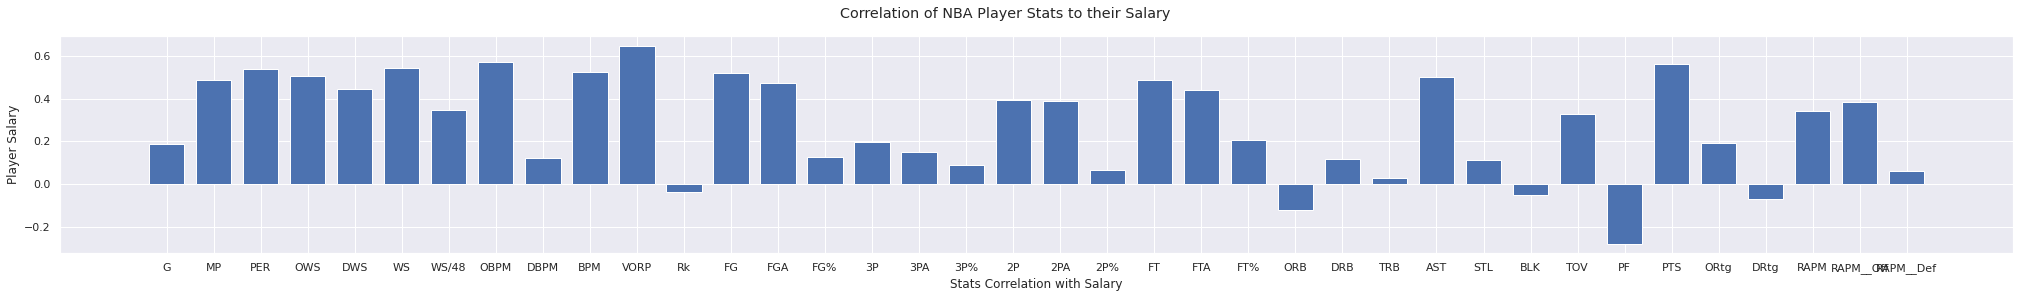

In [ ]:
sns.set()
# generating x coordinates for the bars in the graph
x_pos = np.arange(0,salary_corr_df[:-1].size*2,2)
# plot bar chart
plt.bar(x_pos, salary_corr_df['Salary correlation'][:-1], align='center', width=1.5)
# label bars
plt.xticks(x_pos, salary_corr_df.reset_index()['index'][:-1])
# label axes
plt.xlabel('Stats Correlation with Salary')
plt.ylabel('Player Salary')
# add graph title
plt.suptitle('Correlation of NBA Player Stats to their Salary')
# adjust graph size
plt.gcf().set_size_inches(35,4)

**Salary is more strongly correlated with combinatory advanced stats than any individual stat, with some exceptions, like points scored, field goals, and minutes played. RAPM is the least predictive of these stats despite RAPM often being considered the best indicator of player performance of metrics used in the study.**

Points Scored seems to have one of the highest correlations with player salary (0.558345). Let's try to visualize NBA players' points scored relative to their salaries:

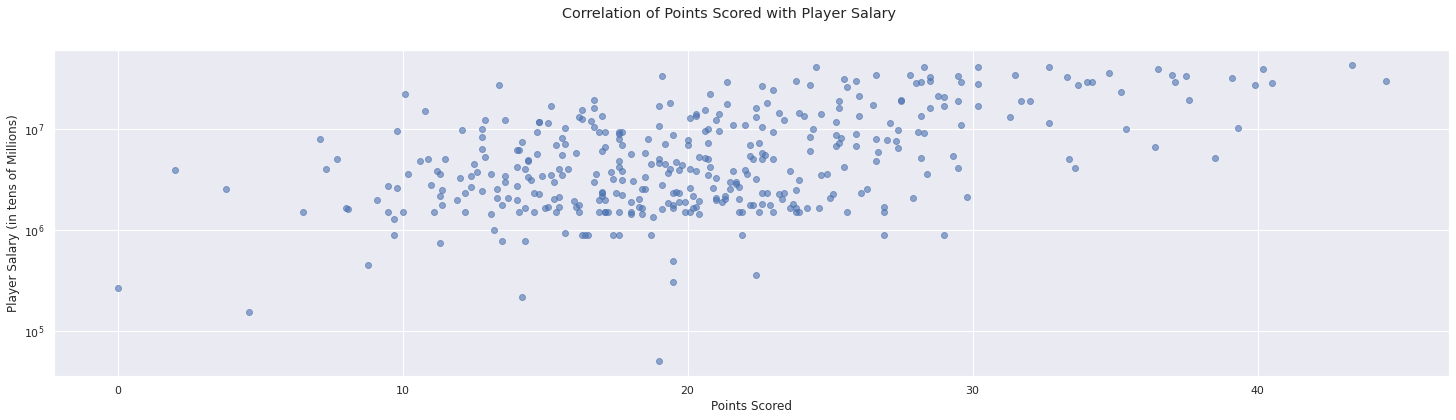

In [ ]:
sns.set()
# scatter plot of points scored relative to player salary
plt.scatter(all_stats_df['PTS'], all_stats_df['Salary 2020-21'], alpha=0.6)
# apply log scale to salary axis to better interpret differences between player salaries
plt.gca().set_yscale('log')
# label axes
plt.xlabel('Points Scored')
plt.ylabel('Player Salary (in tens of Millions)')
# add graph title
plt.suptitle('Correlation of Points Scored with Player Salary')
# adjust graph size
plt.gcf().set_size_inches(25,6)

We can identify a clear upward trend suggesting that the more points a player scores, the higher the salary.

Now let's try to visualize the distribution of more player stats relative to their salaries. The following loop will produce a graph for every stat that has a correlation of 0.45 or above when compared to NBA players' salaries.

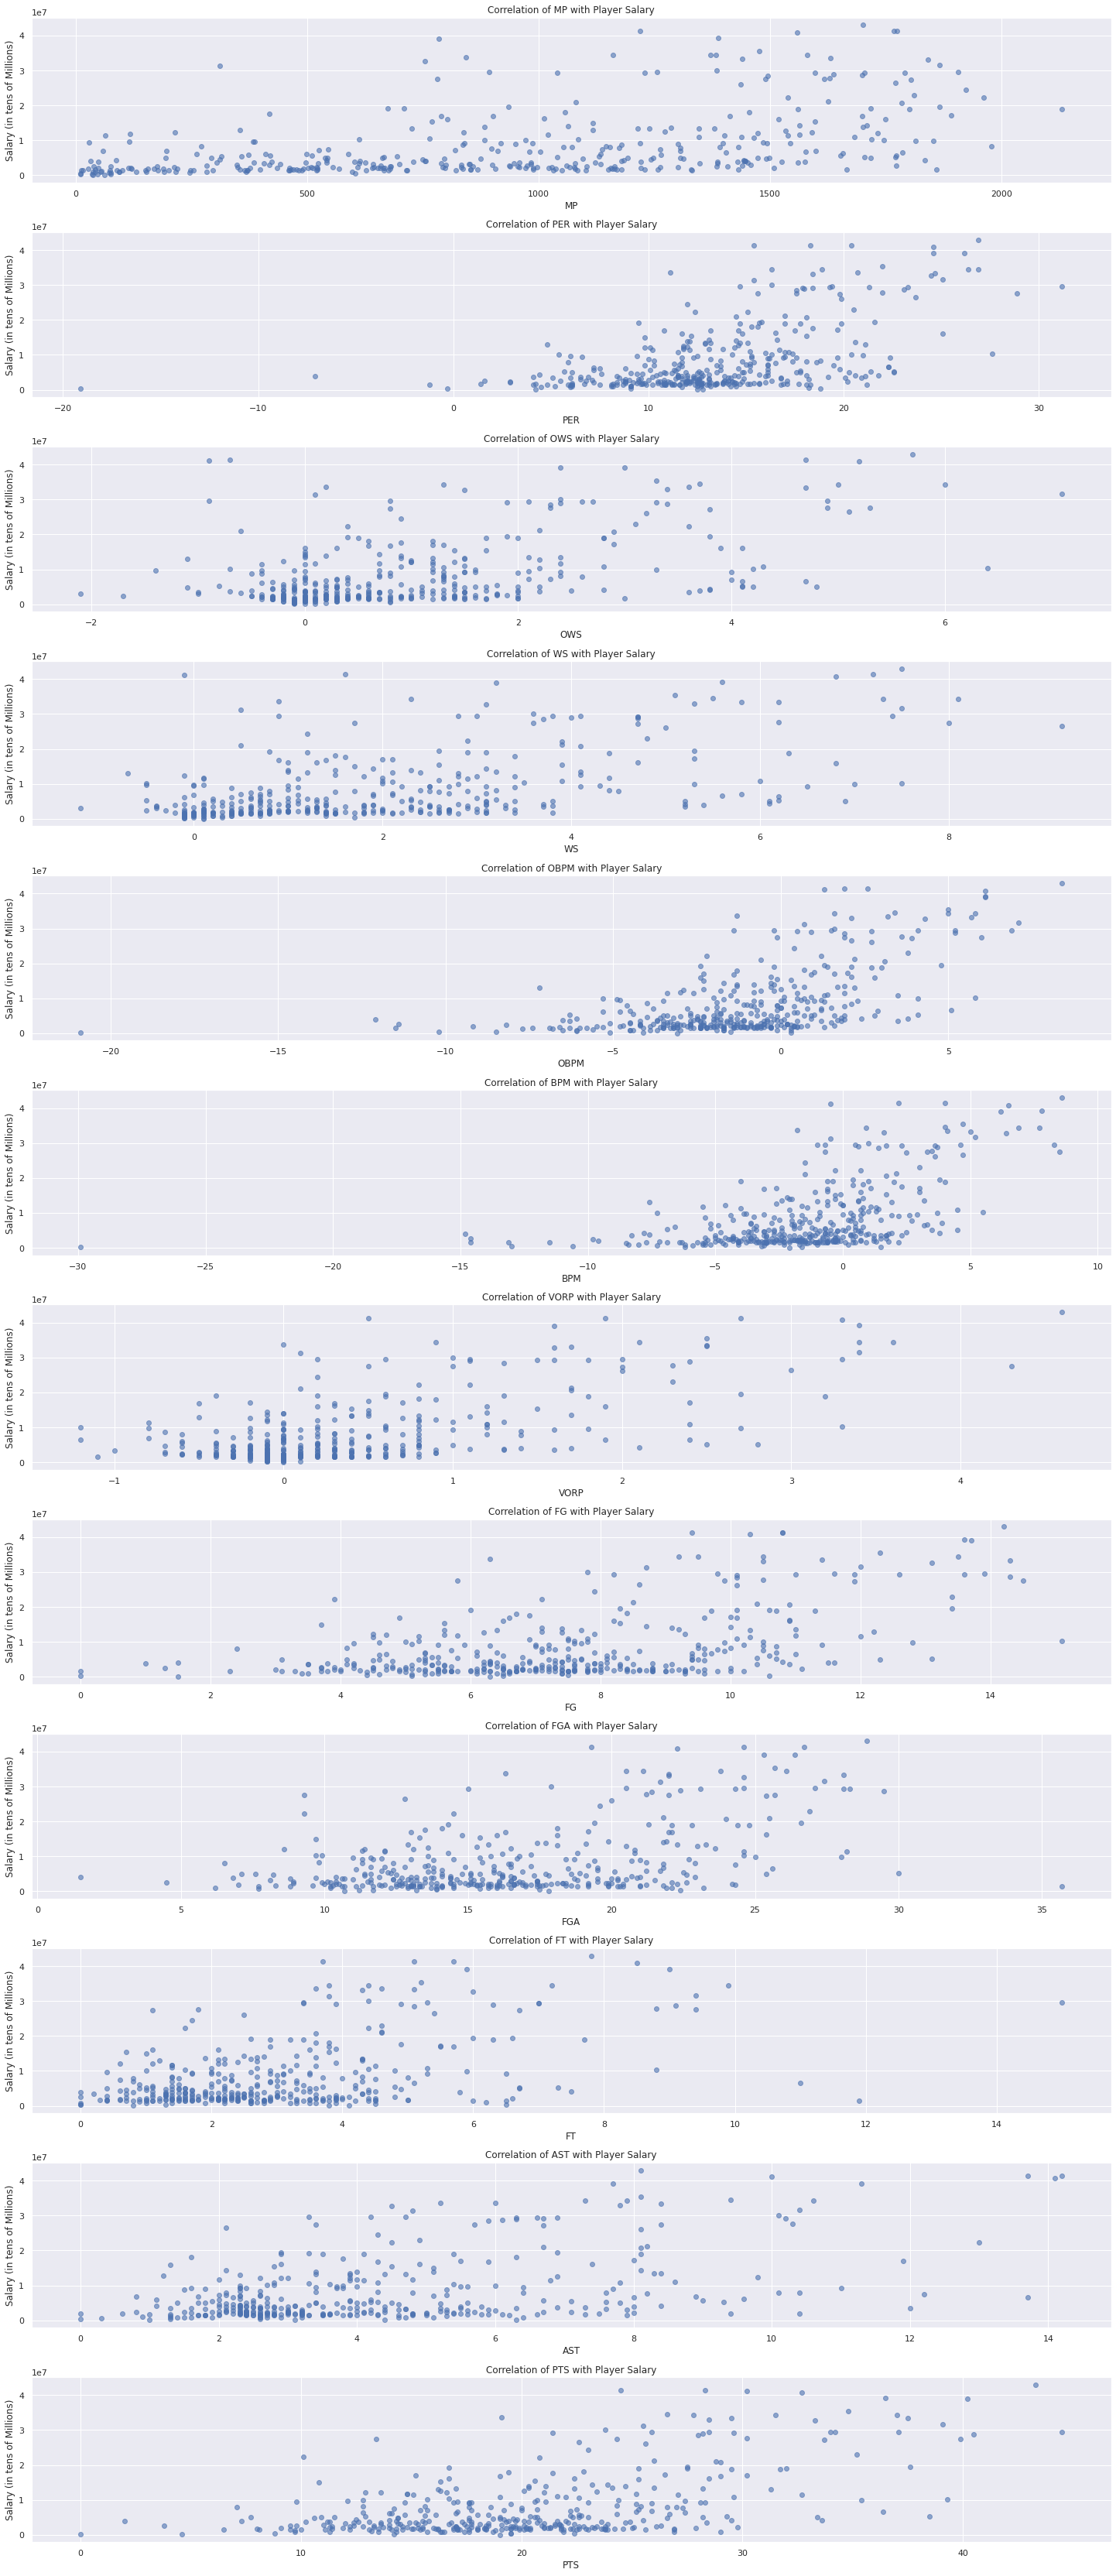

In [ ]:
sns.set()
# determine stats that are strongly correlated with player salary
high_corr = salary_corr_df[salary_corr_df['Salary correlation']>=0.45][:-1]
# create a list of stat names
stats_list = high_corr.index
# loop through different stats
for stat in range(len(stats_list)):
    plt.subplot(len(stats_list), 1, stat+1)
    # graph scatter plot of graph relative to player salary 
    plt.scatter(all_stats_df[stats_list[stat]], all_stats_df['Salary 2020-21'], alpha=0.6)
    # add graph title
    plt.gca().title.set_text(f'Correlation of {stats_list[stat]} with Player Salary')
    # label axes
    plt.xlabel(f'{stats_list[stat]}')
    plt.ylabel('Salary (in tens of Millions)')

# adjusting graph size and spacing between subplots
plt.gcf().set_size_inches(25, 60)
plt.gcf().subplots_adjust(hspace=0.3)

After graphing all these graphs for the data we collected, we started wondering if there was any king of trend between the teams that certain players play for and their salary. To explore this, we chose to graph a scatter plot of players on different teams, along with their salaries:

In [ ]:
px.scatter(data_frame=all_stats_df, x='Tm', y='Salary 2020-21', color='Tm', title='Correlation of Player Teams with Player Salary')

Unfortunatelly, we were unable to identify a clear trend between specific teams and player salaries. We realized that the distribution of capital is different from team to team, since there are several outliers (typically All-Star players).

# **Method**


## 1 - **Lasso Regression**

To predict the value of an NBA player based on his performance, we will use Lasso Regression. This type of regression is a shrinkage and variable selection method for linear regression models. The goal of lasso regression is to obtain the subset of predictors that minimizes prediction error when determining the value of a player. The lasso does this by imposing a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. Variables with a regression coefficient equal to zero after the shrinkage process are excluded from the model. Variables with non-zero regression coefficients variables are most strongly associated with the response variable. 

More detailed information on how Lasso Regression works can be found [here](https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/).

However, there is one downside to using Lasso regression for our predictions:  \

- **The main problem with lasso regression is when we have correlated variables, it retains only one variable and sets other correlated variables to zero. That will possibly lead to some loss of information resulting in lower accuracy in our model.**

## 2 - **Random Forest Regression**


We will fit a Random Forest Regressor to determine the most important features in determining NBA player salary. The Random Forest Regressor determines the feature importance by how much they reduce the gini or probability of predicting the salary incorrectly using many Decision Trees to average out the results. The Random Forest Regressor differs from the Random Forest Classifier in that it is better for determining variably changing prices as opposed to predicting a specific "bucket" that some input falls into, such as species, price bucket, genre, etc.

We the use the Random Forest Regressor to model NBA player salaries by splitting our input data and training our model on some of the data, and then predicting the rest of the data. Then we compare the results of the model to the original sample to see how well our model performed. The Random Forest Regressor is a better solution than a Decision Tree as it constructs several Decision Trees and outputs the mean of all trees as the final prediction. Random Forests help to alleviate the issue of overfitting and generally are more accurate. Their downsides include complexity and larger space and runtime, but we prioritize accuracy for our models. 

For more information on how scikit-learn'
s Random Forest Regressor works, click this link [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). For a more detailed explanation of Random Forest Regression, click [here](https://builtin.com/data-science/random-forest-algorithm)

## 3 - **Polynomial & Exponential Regression**


To be fully thorough, we created polynomial and exponential models to predict NBA player salary. However, these models resulted in low r^2 values and were inferior compared to our models, so we decided not to include them in our final report and focus on Lasso and Random Forest Regression. Nevertheless, we were able to learn that polynomial and exponential regression models do not fit data for predicting NBA player salary well.

# **Results**
Apply the ML method(s) of your choice and graph results.  Be sure to explain the meaning of the graph in simple terms while avoiding interpreting the result in the context of the application just yet.  Please include:
###i.
At least one graph of your ML results.  All graphs should be “self-contained” in that the title, axis labels, legend, caption or other graph elements are sufficient to understand the meaning of the graph without referring to the text of the document.  
###ii.
Beautiful software which is clearly documented and elegantly implemented.

In [ ]:
# Load in data created in Data & Analysis Plan
all_stats_df.head()

,Unnamed: 0,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Rk,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21
0,0,Precious Achiuwa,PF,MIA,54,681,13.9,0.2,1.0,1.2,0.088,-3.5,-0.8,-4.3,-0.4,1,8.1,15.1,0.541,0.0,0.0,NaN,8.1,15.1,0.541,3.8,7.3,0.515,5.1,9.2,14.3,2.0,1.3,1.9,3.0,6.4,20.1,106,108,-1.12,-1.22,0.10,2582160.0
1,1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,0.116,-0.1,-0.6,-0.7,0.5,3,5.8,9.3,0.620,0.0,0.1,0.000,5.8,9.2,0.627,1.8,4.1,0.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0
2,2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,0.193,2.8,1.7,4.5,2.8,4,10.7,18.9,0.566,0.1,0.2,0.250,10.6,18.7,0.570,6.7,8.4,0.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0
3,3,LaMarcus Aldridge,C,TOT,26,674,15.7,0.5,0.7,1.2,0.086,-0.2,-0.4,-0.6,0.2,5,10.1,21.3,0.473,2.2,5.8,0.388,7.8,15.5,0.505,2.9,3.4,0.872,1.4,7.1,8.5,3.5,0.8,2.1,1.9,3.4,25.3,109,112,-0.46,0.01,-0.48,19078340.0
4,21,Nickeil Alexander-Walker,SG,NOP,41,851,12.6,-0.2,0.8,0.6,0.034,-1.6,-0.1,-1.7,0.1,7,9.0,21.5,0.418,3.7,10.6,0.348,5.3,10.9,0.487,2.2,3.0,0.750,0.6,6.6,7.2,4.6,2.3,1.2,3.2,4.4,23.9,101,113,-1.12,-1.05,-0.07,3113160.0


In [ ]:
# Looks like an extra column got added, remove it
all_stats_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# remove and fix some other data
all_stats_df.drop('Rk', axis=1, inplace=True)
all_stats_df.fillna(value=0, inplace=True)
all_stats_df.head()

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21
0,Precious Achiuwa,PF,MIA,54,681,13.9,0.2,1.0,1.2,0.088,-3.5,-0.8,-4.3,-0.4,8.1,15.1,0.541,0.0,0.0,0.000,8.1,15.1,0.541,3.8,7.3,0.515,5.1,9.2,14.3,2.0,1.3,1.9,3.0,6.4,20.1,106,108,-1.12,-1.22,0.10,2582160.0
1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,0.116,-0.1,-0.6,-0.7,0.5,5.8,9.3,0.620,0.0,0.1,0.000,5.8,9.2,0.627,1.8,4.1,0.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0
2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,0.193,2.8,1.7,4.5,2.8,10.7,18.9,0.566,0.1,0.2,0.250,10.6,18.7,0.570,6.7,8.4,0.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0
3,LaMarcus Aldridge,C,TOT,26,674,15.7,0.5,0.7,1.2,0.086,-0.2,-0.4,-0.6,0.2,10.1,21.3,0.473,2.2,5.8,0.388,7.8,15.5,0.505,2.9,3.4,0.872,1.4,7.1,8.5,3.5,0.8,2.1,1.9,3.4,25.3,109,112,-0.46,0.01,-0.48,19078340.0
4,Nickeil Alexander-Walker,SG,NOP,41,851,12.6,-0.2,0.8,0.6,0.034,-1.6,-0.1,-1.7,0.1,9.0,21.5,0.418,3.7,10.6,0.348,5.3,10.9,0.487,2.2,3.0,0.750,0.6,6.6,7.2,4.6,2.3,1.2,3.2,4.4,23.9,101,113,-1.12,-1.05,-0.07,3113160.0


In [ ]:
# Regression data
x_feat_list = all_stats_df.columns[3:-1]
y_feat = 'Salary 2020-21'

x = all_stats_df.loc[:, x_feat_list].values 
y = all_stats_df.loc[:, y_feat].values  

## 1 - Lasso Regression

<a id='lasso'></a>


In [ ]:
# LassoCV automatically performs K-fold cross validation
reg = LassoCV(cv=10).fit(x, y)
y_pred = reg.predict(x)

# print model
model_str = y_feat + f' = {reg.intercept_:.2f}'
for feat, coef in zip(x_feat_list, reg.coef_):
    if (coef != 0):
      model_str += f' + {coef:.2f} {feat}'
print(model_str+'\n')

# compute r2
print('R^2 score:')
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')

Salary 2020-21 = 3136315.79 + -345364.79 G + 12758.01 MP + 192667.02 PER + 163550.61 BPM + 417014.57 AST + 198545.55 PTS + -10794.71 ORtg

R^2 score:
r2 = 0.521


In [ ]:
idx_list = [x for x, z in enumerate(list(reg.coef_)) if z == 0]
feat_ignored = [x_feat_list[i] for i in idx_list]
print("The lasso model ignores the following features: " + str(feat_ignored))
print("In other words, it sets the coefficient of these variables to zero")

The lasso model ignores the following features: ['OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'DRtg', 'RAPM', 'RAPM__Off', 'RAPM__Def']
In other words, it sets the coefficient of these variables to zero


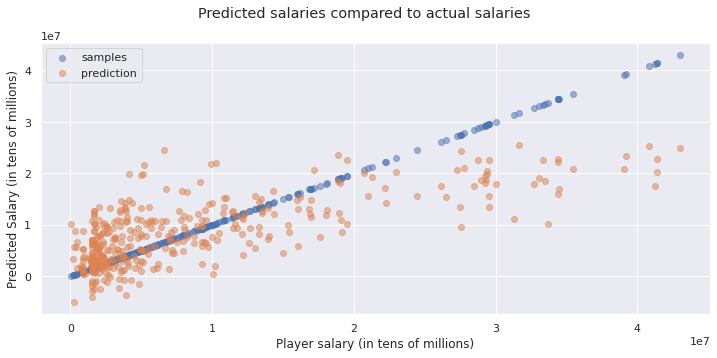

In [ ]:
plt.scatter(pd.Series(y), pd.Series(y), label='samples', alpha=0.5)
plt.scatter(pd.Series(y), pd.Series(y_pred), label='prediction', alpha=0.5)
plt.suptitle('Predicted salaries compared to actual salaries')
plt.ylabel('Predicted Salary (in tens of millions)')
plt.xlabel('Player salary (in tens of millions)')
plt.legend()
plt.gcf().set_size_inches(12, 5)

## 2 - Random Forest Regression
<a id='rf'></a>


In [ ]:
# Regression data
x_feat_list = all_stats_df.columns[3:-1]
y_feat = 'Salary 2020-21'

x = all_stats_df.loc[:, x_feat_list].values 
y = all_stats_df.loc[:, y_feat].values  

In [ ]:
# make k folds
skf = StratifiedKFold(n_splits=10)

# make empty arrays to fill with predictions
y_pred_rf = np.empty_like(y)

# make decision tree and random forest regressorsclassifiers
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

for train_idx, test_idx in skf.split(x, y):
    train_x, train_y = x[train_idx, :], y[train_idx]
    test_x, test_y = x[test_idx, :], y[test_idx]
    
    rf.fit(train_x, train_y)
    
    y_pred_rf[test_idx] = rf.predict(test_x)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_feat_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
print(feature_importances)
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
sorted_x = [pair[0] for pair in feature_importances]
sorted_y = [pair[1] for pair in feature_importances]

[('VORP', 0.21), ('PTS', 0.16), ('OBPM', 0.08), ('MP', 0.06), ('BPM', 0.06), ('FGA', 0.04), ('G', 0.03), ('FT%', 0.03), ('AST', 0.03), ('PER', 0.02), ('STL', 0.02), ('RAPM', 0.02), ('OWS', 0.01), ('DWS', 0.01), ('WS', 0.01), ('WS/48', 0.01), ('DBPM', 0.01), ('FG', 0.01), ('FG%', 0.01), ('3PA', 0.01), ('3P%', 0.01), ('2P', 0.01), ('2PA', 0.01), ('2P%', 0.01), ('FT', 0.01), ('FTA', 0.01), ('ORB', 0.01), ('DRB', 0.01), ('TRB', 0.01), ('BLK', 0.01), ('TOV', 0.01), ('PF', 0.01), ('ORtg', 0.01), ('DRtg', 0.01), ('RAPM__Off', 0.01), ('RAPM__Def', 0.01), ('3P', 0.0)]


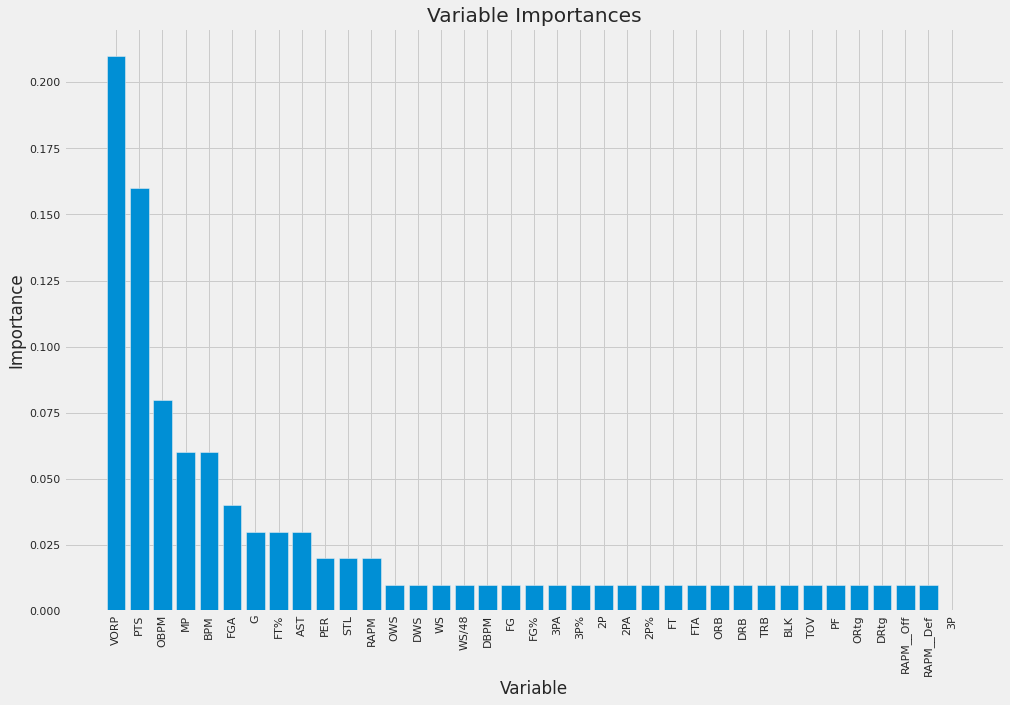

In [ ]:
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(sorted_x)))

# Make a bar chart
plt.bar(x_values, sorted_y, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, sorted_x, rotation='vertical')
  
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.gcf().set_size_inches(15, 10)

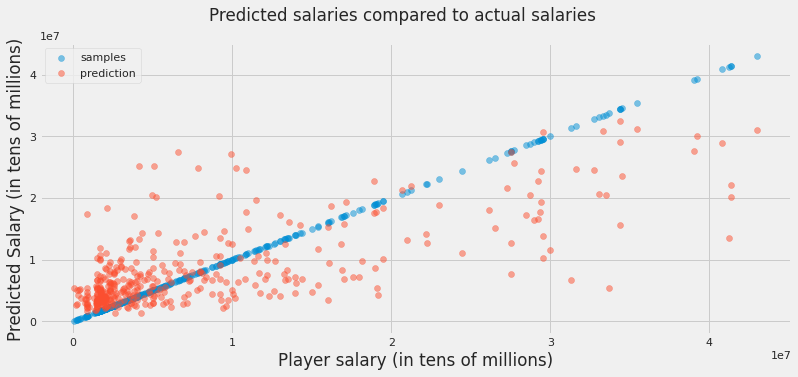

In [ ]:
plt.scatter(pd.Series(y), pd.Series(y), label='samples', alpha=0.5)
plt.scatter(pd.Series(y), pd.Series(y_pred_rf), label='prediction', alpha=0.5)
plt.suptitle('Predicted salaries compared to actual salaries')
plt.ylabel('Predicted Salary (in tens of millions)')
plt.xlabel('Player salary (in tens of millions)')
plt.legend()
plt.gcf().set_size_inches(12, 5)

In [ ]:
# Find mean absolute error
errors = abs(y_pred_rf - y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

Mean Absolute Error: 4723058.91 dollars.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
#print(errors)
#print(test_labels)
r2 = r2_score(y_true=y, y_pred=y_pred_rf)
# compute r2
print(f'R^2 score: {r2:.3}')

Accuracy: -54.92 %.
R^2 score: 0.499


# **Discussion**


## i. **Summary**

<a id='insights'></a>


- Our results allow us to gain insight on things like overpaid and underpaid players and identifying players whose salaries vary greatly from their predicted salaries.

- Although Lasso has a slightly better R^2 score, upon closer inspection the results for Random Forests Regression line up more closely with the results that you might expect.

- Our model correctly predicts overpriced contracts, such as that of Blake Griffin in Detroit, where the team failed to account for his declining health and general level of on-court productivity, leading to an overpriced contract that had to be bought out by the Detroit Pistons.

- Our model portrayed some player salaries such as Chris Paul as being overpriced in comparison to their season statistics, but much of his salary came from playoff experience, veteran status and overall NBA exposure, thus compensating for his lack of statistical prowess. Additionally, he received his contract following

- Donovan Mitchell, on the other hand, was identified as an underpaid player by the model, but the model fails to take into account his rookie contract which does not include his potential for future earnings. It is interesting to see where the model predicts Donovan Mitchell's salary, as his stats clearly outperform his rookie contract and the model depicts that his worth is similar to many other successful players in the league. While this is an indicator of a shortcoming in our model, it actually makes a reasonable prediction for his next salary contract if he continues to play at a high level.





## ii. **Takeaway**

Our project was fairly successful because the methods employed were fairly effective in distinguishing the variables that are critical in determining salary, and discarding the redundant inputs. Additionally it was able to successfully distinguish the leagues most overpaid players

The 'important' features identified by our model are logical in the context of the sport. Metrics such as box plus-minus, points per game, value over replacement player, player efficiency rating and minutes played.

Salaries are based on a player's ability to contribute in relation to other players, so it stands to reason that value over replacement player, player efficiency rating and box plus-minus are effective measures of what a certain player can contribute and deliver for an NBA team.

Shortcomings:

- The model came up short in correctly predicting salaries of rookies and max-contracts. Our model predicts the salary based on tangible statistics related to player ability and skill: it does not factor in intangible aspects, such as years of experience, player status, team salary cap and contract options (bird rights, player/team option, maximum contracts). 

- The model is only utilising 1 year worth of data, and this is hindering the model's ability to correctly predict contracts that were signed before the season based on past performance.

Finding furthest distance players and explaining why their salary is different from our model.

Do players with multi-year contracts affect the salary model?


In [ ]:
# Largest discrepancies in Lasso model
all_stats_df['lasso_pred'] = pd.Series(y_pred)
all_stats_df['lasso_dist'] = all_stats_df['lasso_pred'] - all_stats_df['Salary 2020-21']
all_stats_df['rf_pred'] = y_pred_rf
all_stats_df['rf_dist'] = all_stats_df['rf_pred'] - all_stats_df['Salary 2020-21']
all_stats_df.head()

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
0,Precious Achiuwa,PF,MIA,54,681,13.9,0.2,1.0,1.2,0.088,-3.5,-0.8,-4.3,-0.4,8.1,15.1,0.541,0.0,0.0,0.000,8.1,15.1,0.541,3.8,7.3,0.515,5.1,9.2,14.3,2.0,1.3,1.9,3.0,6.4,20.1,106,108,-1.12,-1.22,0.10,2582160.0,-1.169821e+06,-3.751981e+06,3.795160e+06,1.213000e+06
1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,0.116,-0.1,-0.6,-0.7,0.5,5.8,9.3,0.620,0.0,0.1,0.000,5.8,9.2,0.627,1.8,4.1,0.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0,9.495900e+06,-1.803219e+07,7.595786e+06,-1.993230e+07
2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,0.193,2.8,1.7,4.5,2.8,10.7,18.9,0.566,0.1,0.2,0.250,10.6,18.7,0.570,6.7,8.4,0.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0,1.992170e+07,1.480621e+07,2.523324e+07,2.011775e+07
3,LaMarcus Aldridge,C,TOT,26,674,15.7,0.5,0.7,1.2,0.086,-0.2,-0.4,-0.6,0.2,10.1,21.3,0.473,2.2,5.8,0.388,7.8,15.5,0.505,2.9,3.4,0.872,1.4,7.1,8.5,3.5,0.8,2.1,1.9,3.4,25.3,109,112,-0.46,0.01,-0.48,19078340.0,1.098860e+07,-8.089740e+06,5.368858e+06,-1.370948e+07
4,Nickeil Alexander-Walker,SG,NOP,41,851,12.6,-0.2,0.8,0.6,0.034,-1.6,-0.1,-1.7,0.1,9.0,21.5,0.418,3.7,10.6,0.348,5.3,10.9,0.487,2.2,3.0,0.750,0.6,6.6,7.2,4.6,2.3,1.2,3.2,4.4,23.9,101,113,-1.12,-1.05,-0.07,3113160.0,7.556231e+06,4.443071e+06,4.864923e+06,1.751763e+06


### Most overpaid players (Lasso Regression)

In [ ]:
sorted_distances_lasso = all_stats_df.sort_values('lasso_dist', ascending = False)
sorted_distances_lasso[0:5]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
383,Trae Young,PG,ATL,52,1786,22.3,4.7,1.0,5.6,0.151,5.1,-1.9,3.3,2.4,11.0,25.6,0.431,3.3,9.3,0.357,7.7,16.4,0.472,11.0,12.7,0.871,0.9,4.8,5.7,13.7,1.2,0.3,6.1,2.7,36.4,116,116,1.19,1.80,-0.61,6571800.0,2.448731e+07,1.791551e+07,2.744491e+07,2.087311e+07
250,Donovan Mitchell,PG,UTA,53,1771,21.4,4.1,2.1,6.2,0.168,4.1,-0.6,3.5,2.5,13.1,30.0,0.438,4.9,12.7,0.386,8.2,17.3,0.476,7.3,8.7,0.845,1.4,5.1,6.5,7.6,1.4,0.4,4.0,3.2,38.5,115,111,1.06,1.20,-0.13,5195501.0,2.169383e+07,1.649833e+07,2.020809e+07,1.501259e+07
128,Shai Gilgeous-Alexander,SG,OKC,35,1180,21.8,2.8,0.9,3.7,0.149,3.8,0.0,3.8,1.7,11.6,22.9,0.508,2.9,6.9,0.418,8.7,16.0,0.547,7.5,9.3,0.808,0.8,5.9,6.7,8.4,1.1,0.9,4.3,2.8,33.6,118,114,-0.74,0.93,-1.67,4141320.0,1.982491e+07,1.568359e+07,2.524025e+07,2.109893e+07
2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,0.193,2.8,1.7,4.5,2.8,10.7,18.9,0.566,0.1,0.2,0.250,10.6,18.7,0.570,6.7,8.4,0.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0,1.992170e+07,1.480621e+07,2.523324e+07,2.011775e+07
324,Collin Sexton,SG,CLE,48,1718,17.8,2.2,0.9,3.1,0.087,1.6,-1.8,-0.2,0.8,12.3,25.4,0.482,2.2,6.0,0.370,10.0,19.5,0.516,6.7,8.2,0.818,1.2,2.9,4.1,5.6,1.5,0.2,3.6,3.7,33.4,111,117,-1.60,-1.61,0.02,4991880.0,1.964231e+07,1.465043e+07,2.054852e+07,1.555664e+07


### Most Overpaid Players (Random Forest Regression)

In [ ]:
# Largest discrepancy in random forests we will find
sorted_distances_rf = all_stats_df.sort_values('rf_dist', ascending=True)
sorted_distances_rf[0:8]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
141,Blake Griffin,PF,TOT,31,844,11.1,0.2,0.7,0.9,0.051,-1.3,-0.5,-1.8,0.0,6.3,16.3,0.388,2.9,8.7,0.333,3.4,7.6,0.450,3.6,5.0,0.724,0.8,8.0,8.7,6.0,1.3,0.4,2.7,3.8,19.1,105,113,-0.64,-0.56,-0.08,33685241.0,1.020284e+07,-2.348240e+07,5.391291e+06,-2.829395e+07
361,John Wall,PG,HOU,38,1219,15.4,-0.9,0.8,-0.1,-0.004,1.3,-1.8,-0.5,0.5,10.8,26.7,0.403,3.0,9.2,0.325,7.8,17.5,0.444,5.7,7.7,0.737,0.7,4.1,4.8,10.0,1.6,1.1,5.2,1.7,30.2,99,115,-1.53,-1.32,-0.20,41254920.0,1.754731e+07,-2.370761e+07,1.352029e+07,-2.773463e+07
222,Kevin Love,PF,CLE,14,311,15.4,0.1,0.3,0.5,0.074,0.7,-1.1,-0.5,0.1,8.7,21.7,0.401,4.3,13.5,0.318,4.4,8.2,0.538,3.8,4.9,0.774,1.6,12.7,14.3,4.8,1.3,0.3,2.7,2.2,25.5,106,112,0.60,0.26,0.34,31300000.0,1.107459e+07,-2.022541e+07,6.675766e+06,-2.462423e+07
366,Russell Westbrook,PG,WAS,50,1775,18.3,-0.7,2.3,1.6,0.042,1.9,0.4,2.2,1.9,10.8,24.6,0.438,1.7,5.4,0.311,9.1,19.2,0.474,5.1,8.2,0.618,2.2,12.1,14.2,14.2,1.7,0.5,6.5,3.6,28.3,101,110,-2.07,-1.84,-0.23,41358814.0,2.284934e+07,-1.850948e+07,2.022090e+07,-2.113791e+07
1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,0.116,-0.1,-0.6,-0.7,0.5,5.8,9.3,0.620,0.0,0.1,0.000,5.8,9.2,0.627,1.8,4.1,0.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0,9.495900e+06,-1.803219e+07,7.595786e+06,-1.993230e+07
370,Andrew Wiggins,PF,GSW,58,1906,14.7,0.8,2.0,2.8,0.071,-0.2,-0.6,-0.7,0.6,9.8,20.5,0.477,2.9,7.4,0.388,6.9,13.2,0.527,3.4,4.9,0.695,1.4,5.5,6.8,3.3,1.3,1.4,2.6,3.1,25.9,106,112,-0.62,-1.61,0.99,29542010.0,1.551388e+07,-1.402813e+07,1.029262e+07,-1.924939e+07
287,Chris Paul,PG,PHO,56,1767,20.4,4.7,2.5,7.2,0.194,2.6,1.4,4.0,2.7,9.4,19.3,0.484,2.0,5.6,0.365,7.3,13.8,0.532,3.7,4.0,0.931,0.6,6.6,7.2,13.7,2.3,0.3,3.3,3.6,24.5,122,109,2.16,0.82,1.34,41358814.0,2.018441e+07,-2.117441e+07,2.217323e+07,-1.918558e+07
360,Kemba Walker,PG,BOS,37,1161,16.3,1.3,1.0,2.3,0.095,1.6,-0.7,0.9,0.9,9.5,23.8,0.401,4.3,12.5,0.345,5.2,11.3,0.464,4.4,4.7,0.937,0.5,5.6,6.1,7.9,1.7,0.4,3.2,2.2,27.8,111,114,-0.03,0.07,-0.11,34379100.0,1.607330e+07,-1.830580e+07,1.567379e+07,-1.870531e+07


### What players does the model predict to have the greatest worth?

### Players Predicted To Have Highest Salary Lasso

In [ ]:
sorted_predictions_lasso_over = all_stats_df.sort_values('lasso_pred', ascending=False)
sorted_predictions_lasso_over[0:9]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
217,Damian Lillard,PG,POR,52,1867,25.1,7.1,0.4,7.5,0.194,7.1,-1.9,5.2,3.4,12.0,27.4,0.440,5.6,14.7,0.379,6.5,12.7,0.510,9.4,10.2,0.925,0.7,5.0,5.7,10.4,1.2,0.4,4.3,2.2,39.1,123,119,0.49,2.82,-2.33,31626953.0,2.545528e+07,-6.171670e+06,2.470541e+07,-6.921548e+06
146,James Harden,PG-SG,TOT,42,1558,24.6,5.2,1.6,6.8,0.209,6.1,0.4,6.5,3.3,10.3,22.3,0.463,3.6,10.1,0.358,6.7,12.2,0.549,8.5,9.8,0.870,1.1,9.3,10.4,14.1,1.5,0.9,5.3,2.9,32.7,122,112,1.21,2.55,-1.34,40824000.0,2.536605e+07,-1.545795e+07,2.889217e+07,-1.193183e+07
88,Stephen Curry,PG,GSW,50,1701,26.9,5.7,1.8,7.5,0.212,8.4,0.2,8.6,4.6,14.2,28.9,0.491,7.2,16.6,0.431,7.0,12.2,0.573,7.8,8.4,0.922,0.7,6.9,7.6,8.1,1.7,0.2,4.5,2.5,43.3,121,112,1.97,2.57,-0.60,43006362.0,2.482740e+07,-1.817896e+07,3.105049e+07,-1.195587e+07
383,Trae Young,PG,ATL,52,1786,22.3,4.7,1.0,5.6,0.151,5.1,-1.9,3.3,2.4,11.0,25.6,0.431,3.3,9.3,0.357,7.7,16.4,0.472,11.0,12.7,0.871,0.9,4.8,5.7,13.7,1.2,0.3,6.1,2.7,36.4,116,116,1.19,1.80,-0.61,6571800.0,2.448731e+07,1.791551e+07,2.744491e+07,2.087311e+07
9,Giannis Antetokounmpo,PF,MIL,48,1618,28.9,5.3,2.7,8.0,0.238,6.0,2.5,8.5,4.3,14.5,25.7,0.564,1.5,5.1,0.297,13.0,20.6,0.630,9.4,13.7,0.688,2.4,13.2,15.6,8.4,1.6,1.8,5.2,3.8,39.9,120,107,3.18,1.91,1.27,27528090.0,2.428904e+07,-3.239048e+06,2.736316e+07,-1.649332e+05
304,Julius Randle,PF,NYK,57,2131,19.9,2.8,3.5,6.3,0.143,3.0,0.9,4.0,3.2,11.3,24.4,0.461,2.8,6.9,0.405,8.5,17.5,0.483,6.3,7.9,0.802,1.7,12.3,14.0,8.1,1.3,0.4,4.6,4.2,31.7,111,107,1.47,0.12,1.35,18900000.0,2.359961e+07,4.699609e+06,2.280318e+07,3.903179e+06
182,LeBron James,PG,LAL,41,1388,24.6,3.0,2.6,5.6,0.193,6.1,1.7,7.8,3.4,13.6,26.4,0.513,3.4,9.3,0.368,10.1,17.1,0.592,5.9,8.4,0.703,0.8,10.5,11.3,11.3,1.5,0.8,5.3,2.3,36.5,115,105,3.49,1.64,1.85,39219565.0,2.341756e+07,-1.580200e+07,3.005455e+07,-9.165015e+06
366,Russell Westbrook,PG,WAS,50,1775,18.3,-0.7,2.3,1.6,0.042,1.9,0.4,2.2,1.9,10.8,24.6,0.438,1.7,5.4,0.311,9.1,19.2,0.474,5.1,8.2,0.618,2.2,12.1,14.2,14.2,1.7,0.5,6.5,3.6,28.3,101,110,-2.07,-1.84,-0.23,41358814.0,2.284934e+07,-1.850948e+07,2.022090e+07,-2.113791e+07
213,Kawhi Leonard,SF,LAC,46,1581,26.9,6.0,2.2,8.1,0.246,5.8,1.1,6.9,3.6,13.5,26.1,0.516,2.8,7.2,0.393,10.7,19.0,0.562,7.2,8.2,0.878,1.6,8.0,9.6,7.3,2.4,0.6,2.8,2.4,37.0,126,109,3.98,2.94,1.03,34379100.0,2.276144e+07,-1.161766e+07,3.250866e+07,-1.870443e+06


### Players Predicted To Have Highest Salary Random Forest Regression

In [ ]:
sorted_predictions_rf_over = all_stats_df.sort_values('rf_pred', ascending=False)
sorted_predictions_rf_over[0:9]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
213,Kawhi Leonard,SF,LAC,46,1581,26.9,6.0,2.2,8.1,0.246,5.8,1.1,6.9,3.6,13.5,26.1,0.516,2.8,7.2,0.393,10.7,19.0,0.562,7.2,8.2,0.878,1.6,8.0,9.6,7.3,2.4,0.6,2.8,2.4,37.0,126,109,3.98,2.94,1.03,34379100.0,2.276144e+07,-1.161766e+07,3.250866e+07,-1.870443e+06
126,Paul George,SF,LAC,44,1477,22.0,3.3,1.8,5.1,0.165,5.0,-0.3,4.7,2.5,12.3,25.7,0.480,4.9,11.1,0.437,7.5,14.6,0.513,5.2,5.9,0.886,1.3,7.9,9.2,8.1,1.7,0.7,4.8,3.5,34.8,116,111,3.75,2.03,1.72,35450412.0,2.082622e+07,-1.462419e+07,3.112456e+07,-4.325857e+06
88,Stephen Curry,PG,GSW,50,1701,26.9,5.7,1.8,7.5,0.212,8.4,0.2,8.6,4.6,14.2,28.9,0.491,7.2,16.6,0.431,7.0,12.2,0.573,7.8,8.4,0.922,0.7,6.9,7.6,8.1,1.7,0.2,4.5,2.5,43.3,121,112,1.97,2.57,-0.60,43006362.0,2.482740e+07,-1.817896e+07,3.105049e+07,-1.195587e+07
177,Kyrie Irving,PG,BRK,41,1440,24.7,4.7,1.1,5.8,0.195,5.7,-0.7,5.0,2.5,14.3,28.1,0.511,3.7,9.5,0.389,10.6,18.5,0.573,5.1,5.6,0.916,1.5,5.1,6.5,8.4,1.7,0.8,3.2,3.7,37.5,122,114,2.34,2.30,0.05,33329100.0,2.255594e+07,-1.077316e+07,3.091413e+07,-2.414973e+06
108,Joel Embiid,C,PHI,39,1257,31.2,4.9,2.6,7.4,0.284,6.9,1.4,8.3,3.3,13.9,27.1,0.512,1.7,4.5,0.378,12.2,22.6,0.539,15.0,17.6,0.853,3.2,13.3,16.6,4.7,1.5,2.1,4.6,3.5,44.5,123,103,3.25,1.85,1.40,29542010.0,2.254008e+07,-7.001930e+06,3.061114e+07,1.069132e+06
182,LeBron James,PG,LAL,41,1388,24.6,3.0,2.6,5.6,0.193,6.1,1.7,7.8,3.4,13.6,26.4,0.513,3.4,9.3,0.368,10.1,17.1,0.592,5.9,8.4,0.703,0.8,10.5,11.3,11.3,1.5,0.8,5.3,2.3,36.5,115,105,3.49,1.64,1.85,39219565.0,2.341756e+07,-1.580200e+07,3.005455e+07,-9.165015e+06
62,Jimmy Butler,SF,MIA,41,1383,26.4,5.0,2.3,7.3,0.254,5.0,2.7,7.7,3.4,10.5,21.1,0.495,0.7,2.9,0.232,9.8,18.2,0.537,9.9,11.6,0.852,2.8,7.8,10.5,10.6,3.1,0.6,3.1,2.1,31.5,126,107,2.69,1.15,1.54,34379100.0,2.228084e+07,-1.209826e+07,2.907803e+07,-5.301067e+06
146,James Harden,PG-SG,TOT,42,1558,24.6,5.2,1.6,6.8,0.209,6.1,0.4,6.5,3.3,10.3,22.3,0.463,3.6,10.1,0.358,6.7,12.2,0.549,8.5,9.8,0.870,1.1,9.3,10.4,14.1,1.5,0.9,5.3,2.9,32.7,122,112,1.21,2.55,-1.34,40824000.0,2.536605e+07,-1.545795e+07,2.889217e+07,-1.193183e+07
102,Kevin Durant,PF,BRK,24,784,26.2,2.4,0.8,3.2,0.197,6.1,0.1,6.2,1.6,13.7,25.3,0.543,3.8,8.1,0.462,10.0,17.2,0.581,9.0,10.4,0.870,0.6,9.4,9.9,7.7,0.9,1.9,5.5,3.0,40.2,121,113,2.11,2.09,0.02,39058950.0,2.079811e+07,-1.826084e+07,2.753355e+07,-1.152540e+07


### Most Underpaid Player Lasso

In [ ]:
sorted_predictions_lasso_under = all_stats_df.sort_values('lasso_dist', ascending=True)
sorted_predictions_lasso_under[0:9]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
361,John Wall,PG,HOU,38,1219,15.4,-0.9,0.8,-0.1,-0.004,1.3,-1.8,-0.5,0.5,10.8,26.7,0.403,3.0,9.2,0.325,7.8,17.5,0.444,5.7,7.7,0.737,0.7,4.1,4.8,10.0,1.6,1.1,5.2,1.7,30.2,99,115,-1.53,-1.32,-0.20,41254920.0,1.754731e+07,-2.370761e+07,1.352029e+07,-2.773463e+07
141,Blake Griffin,PF,TOT,31,844,11.1,0.2,0.7,0.9,0.051,-1.3,-0.5,-1.8,0.0,6.3,16.3,0.388,2.9,8.7,0.333,3.4,7.6,0.450,3.6,5.0,0.724,0.8,8.0,8.7,6.0,1.3,0.4,2.7,3.8,19.1,105,113,-0.64,-0.56,-0.08,33685241.0,1.020284e+07,-2.348240e+07,5.391291e+06,-2.829395e+07
287,Chris Paul,PG,PHO,56,1767,20.4,4.7,2.5,7.2,0.194,2.6,1.4,4.0,2.7,9.4,19.3,0.484,2.0,5.6,0.365,7.3,13.8,0.532,3.7,4.0,0.931,0.6,6.6,7.2,13.7,2.3,0.3,3.3,3.6,24.5,122,109,2.16,0.82,1.34,41358814.0,2.018441e+07,-2.117441e+07,2.217323e+07,-1.918558e+07
222,Kevin Love,PF,CLE,14,311,15.4,0.1,0.3,0.5,0.074,0.7,-1.1,-0.5,0.1,8.7,21.7,0.401,4.3,13.5,0.318,4.4,8.2,0.538,3.8,4.9,0.774,1.6,12.7,14.3,4.8,1.3,0.3,2.7,2.2,25.5,106,112,0.60,0.26,0.34,31300000.0,1.107459e+07,-2.022541e+07,6.675766e+06,-2.462423e+07
366,Russell Westbrook,PG,WAS,50,1775,18.3,-0.7,2.3,1.6,0.042,1.9,0.4,2.2,1.9,10.8,24.6,0.438,1.7,5.4,0.311,9.1,19.2,0.474,5.1,8.2,0.618,2.2,12.1,14.2,14.2,1.7,0.5,6.5,3.6,28.3,101,110,-2.07,-1.84,-0.23,41358814.0,2.284934e+07,-1.850948e+07,2.022090e+07,-2.113791e+07
360,Kemba Walker,PG,BOS,37,1161,16.3,1.3,1.0,2.3,0.095,1.6,-0.7,0.9,0.9,9.5,23.8,0.401,4.3,12.5,0.345,5.2,11.3,0.464,4.4,4.7,0.937,0.5,5.6,6.1,7.9,1.7,0.4,3.2,2.2,27.8,111,114,-0.03,0.07,-0.11,34379100.0,1.607330e+07,-1.830580e+07,1.567379e+07,-1.870531e+07
102,Kevin Durant,PF,BRK,24,784,26.2,2.4,0.8,3.2,0.197,6.1,0.1,6.2,1.6,13.7,25.3,0.543,3.8,8.1,0.462,10.0,17.2,0.581,9.0,10.4,0.870,0.6,9.4,9.9,7.7,0.9,1.9,5.5,3.0,40.2,121,113,2.11,2.09,0.02,39058950.0,2.079811e+07,-1.826084e+07,2.753355e+07,-1.152540e+07
88,Stephen Curry,PG,GSW,50,1701,26.9,5.7,1.8,7.5,0.212,8.4,0.2,8.6,4.6,14.2,28.9,0.491,7.2,16.6,0.431,7.0,12.2,0.573,7.8,8.4,0.922,0.7,6.9,7.6,8.1,1.7,0.2,4.5,2.5,43.3,121,112,1.97,2.57,-0.60,43006362.0,2.482740e+07,-1.817896e+07,3.105049e+07,-1.195587e+07
1,Steven Adams,C,NOP,53,1491,15.6,2.3,1.3,3.6,0.116,-0.1,-0.6,-0.7,0.5,5.8,9.3,0.620,0.0,0.1,0.000,5.8,9.2,0.627,1.8,4.1,0.441,6.7,8.9,15.6,3.4,1.6,1.1,2.4,3.4,13.4,123,114,0.83,1.09,-0.26,27528090.0,9.495900e+06,-1.803219e+07,7.595786e+06,-1.993230e+07


### Most Underpaid Player Random Forests Regression

In [ ]:
sorted_predictions_rf_under = all_stats_df.sort_values('rf_dist', ascending=False)
sorted_predictions_rf_under[0:9]

,Player,Pos,Tm,G,MP,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,RAPM,RAPM__Off,RAPM__Def,Salary 2020-21,lasso_pred,lasso_dist,rf_pred,rf_dist
128,Shai Gilgeous-Alexander,SG,OKC,35,1180,21.8,2.8,0.9,3.7,0.149,3.8,0.0,3.8,1.7,11.6,22.9,0.508,2.9,6.9,0.418,8.7,16.0,0.547,7.5,9.3,0.808,0.8,5.9,6.7,8.4,1.1,0.9,4.3,2.8,33.6,118,114,-0.74,0.93,-1.67,4141320.0,1.982491e+07,1.568359e+07,2.524025e+07,2.109893e+07
383,Trae Young,PG,ATL,52,1786,22.3,4.7,1.0,5.6,0.151,5.1,-1.9,3.3,2.4,11.0,25.6,0.431,3.3,9.3,0.357,7.7,16.4,0.472,11.0,12.7,0.871,0.9,4.8,5.7,13.7,1.2,0.3,6.1,2.7,36.4,116,116,1.19,1.80,-0.61,6571800.0,2.448731e+07,1.791551e+07,2.744491e+07,2.087311e+07
2,Bam Adebayo,C,MIA,51,1705,22.6,4.2,2.7,6.9,0.193,2.8,1.7,4.5,2.8,10.7,18.9,0.566,0.1,0.2,0.250,10.6,18.7,0.570,6.7,8.4,0.803,3.5,10.4,13.8,7.8,1.5,1.7,4.1,3.4,28.2,120,107,-0.14,0.02,-0.17,5115492.0,1.992170e+07,1.480621e+07,2.523324e+07,2.011775e+07
339,Jayson Tatum,SF,BOS,52,1853,21.0,3.3,2.0,5.3,0.136,4.1,-0.4,3.7,2.7,12.8,28.0,0.457,4.0,10.3,0.387,8.8,17.7,0.499,5.9,6.7,0.874,0.9,9.1,10.0,6.0,1.7,0.6,3.5,2.5,35.4,114,112,2.18,1.70,0.48,9897120.0,2.176908e+07,1.187196e+07,2.715295e+07,1.725583e+07
21,LaMelo Ball,PG,CHO,41,1174,18.6,1.4,1.5,2.9,0.119,1.9,0.8,2.7,1.4,9.8,21.8,0.451,3.4,8.9,0.375,6.5,12.8,0.503,4.0,5.1,0.789,2.2,7.7,9.9,10.4,2.7,0.6,4.8,4.8,27.0,111,110,-0.89,-0.15,-0.75,7839960.0,1.647892e+07,8.638961e+06,2.490405e+07,1.706409e+07
171,Elijah Hughes,SF,UTA,12,42,13.2,0.0,0.1,0.0,0.039,0.3,-0.1,0.2,0.0,9.3,23.2,0.400,7.0,17.4,0.400,2.3,5.8,0.400,3.5,4.6,0.750,0.0,8.1,8.1,4.6,1.2,1.2,5.8,1.2,29.0,99,109,-0.66,-0.44,-0.22,898310.0,8.711102e+06,7.812792e+06,1.732413e+07,1.642582e+07
303,Immanuel Quickley,PG,NYK,53,1023,16.0,1.5,1.2,2.7,0.125,1.6,-0.9,0.7,0.7,9.3,24.2,0.383,4.6,12.3,0.375,4.6,11.9,0.391,6.6,7.4,0.894,1.1,4.8,5.9,5.4,1.2,0.5,2.2,4.7,29.8,113,111,0.43,0.47,-0.04,2105520.0,8.029314e+06,5.923794e+06,1.832429e+07,1.621877e+07
324,Collin Sexton,SG,CLE,48,1718,17.8,2.2,0.9,3.1,0.087,1.6,-1.8,-0.2,0.8,12.3,25.4,0.482,2.2,6.0,0.370,10.0,19.5,0.516,6.7,8.2,0.818,1.2,2.9,4.1,5.6,1.5,0.2,3.6,3.7,33.4,111,117,-1.60,-1.61,0.02,4991880.0,1.964231e+07,1.465043e+07,2.054852e+07,1.555664e+07
250,Donovan Mitchell,PG,UTA,53,1771,21.4,4.1,2.1,6.2,0.168,4.1,-0.6,3.5,2.5,13.1,30.0,0.438,4.9,12.7,0.386,8.2,17.3,0.476,7.3,8.7,0.845,1.4,5.1,6.5,7.6,1.4,0.4,4.0,3.2,38.5,115,111,1.06,1.20,-0.13,5195501.0,2.169383e+07,1.649833e+07,2.020809e+07,1.501259e+07


## iii. Future Research

- Basic improvements on the current model would be incorporating data from multiple years. Additionally we could implement a classifier that determines the type of contracts that a player might receives in order to account for special salary exceptions like Bird rights.

- The biggest problem with this model is that it does not determine any systematic errors within NBA player salary determination. It would be possible using RAPM data to determine a concrete number of wins that a player has added over a season. You could then use machine learning to determine the value of a win and create a player salary estimation that is based solely on objective performance. 